### Segmentation of a blood vessel dataset
To download the dataset, run the following cell:

In [ ]:
#from dataset_vessel import download
#download(directory='data')

In [ ]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import train_vessel
import torchtrainer

params = {
    # Dataset
    'img_dir': Path('data/vessel/images'),     # Images path
    'label_dir': Path('data/vessel/labels'),   # Labels path   
    'train_val_split': 0.1,                    # Train/validation split
    'use_transforms': False,                   # If False, do not use data augmentation
    # Model
    'model_layers': (1, 1, 1),                 # Number of residual blocks at each layer of the model
    'model_channels': (16,32,64),              # Number of channels at each layer
    'model_type': 'unet',                      # Model to use
    # Training
    'epochs': 200,
    'lr': 0.01,
    'batch_size_train': 8,
    'batch_size_valid': 8, 
    'momentum': 0.9,                           # Momentum for optimizer
    'weight_decay': 0.,
    'seed': 12,                                # Seed for random number generators
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,                    # Power por the polynomial scheduler
    'class_weights': (0.3414, 0.6586),         # Class weights to use for cross entropy calculation
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,                          # Number of workers for the dataloader
    'use_amp': True,                           # Mixed precision
    'pin_memory': False,
    'non_blocking': False,
    # Logging
    'log_dir': 'logs/',                        # Directory for logging metrics and model checkpoints
    'experiment':'unet_l_1_1_1_c_16_32_64',    # Experiment tag
    'save_every':1,                            # Number of epochs between checkpoints     
    'save_best':True,                          # Save model with best validation loss
    'meta': None,                              # Additional metadata to save
    # Other 
    'resume': False                            # Resume from previous training
}

logger, ds_train, ds_valid, model = train_vessel.run(params)

### View results

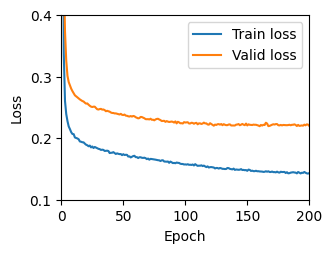

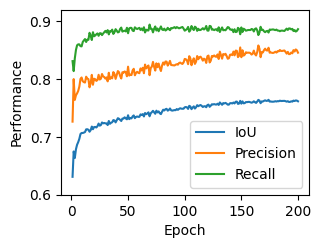

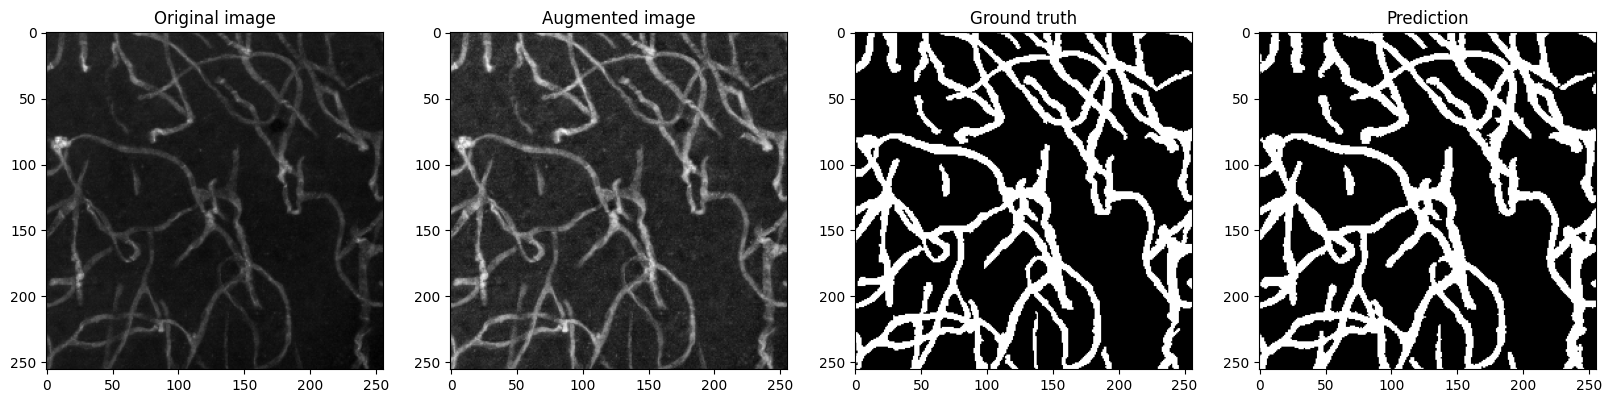

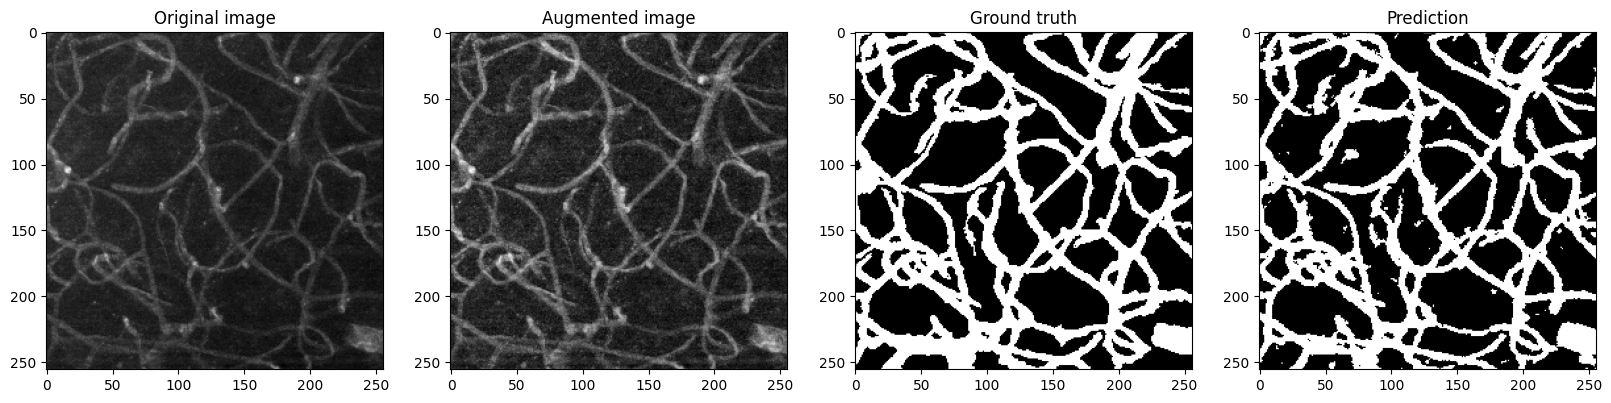

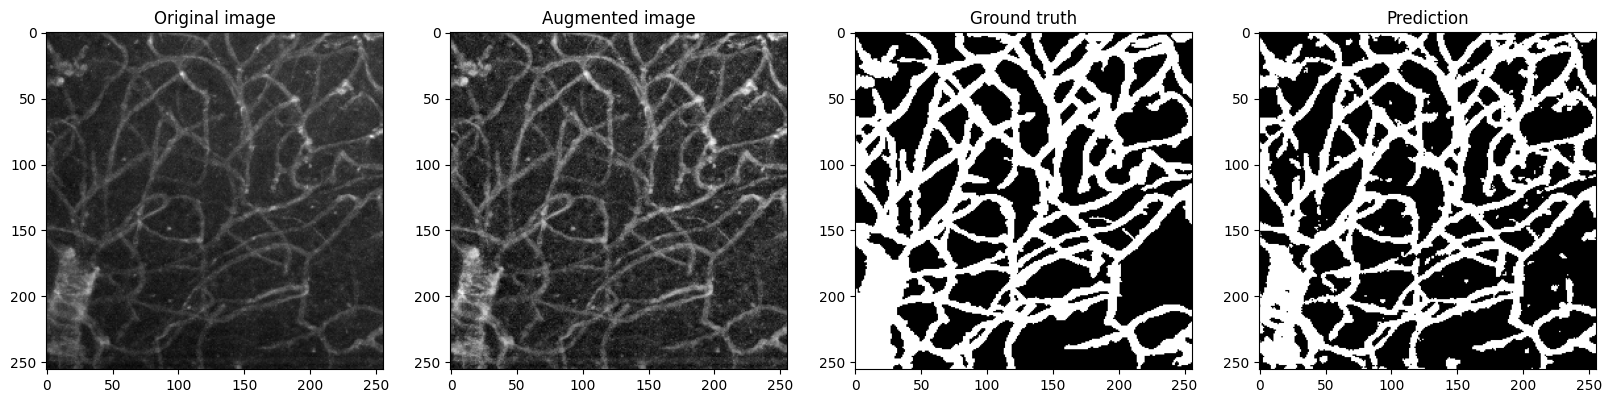

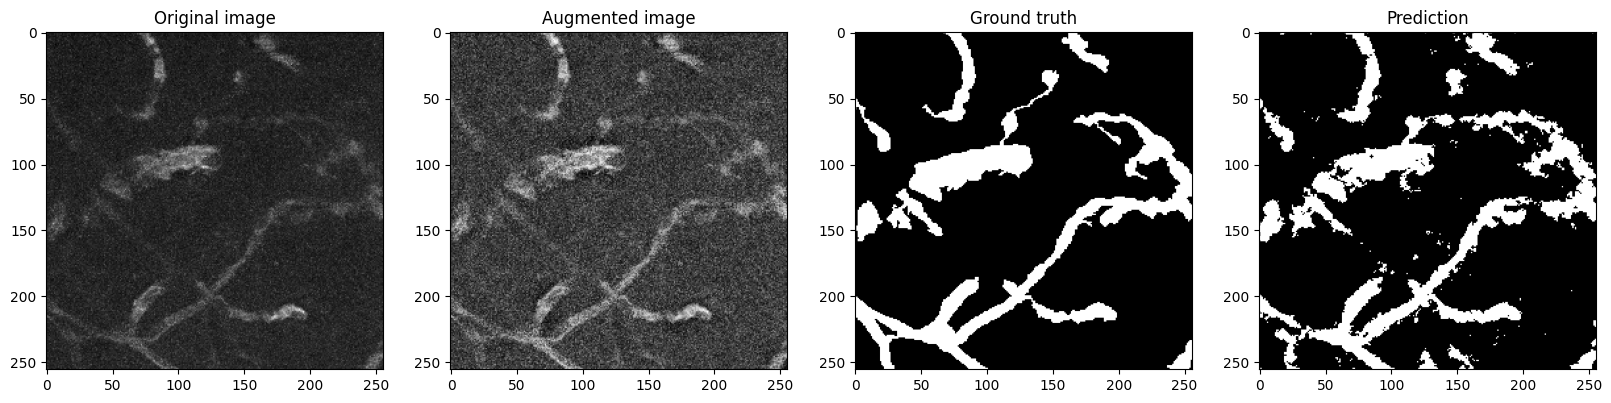

In [3]:
# Plot results
def plot_metrics(logger):
    '''Plot losses and IoU.''' 
    
    epochs, metrics = zip(*logger.data.items())
    train_loss, valid_loss, iou, prec, rec = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0.1, 0.4))
    plt.xlim((0, 200))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.ylim((0.6, 0.92))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=4):
    """Plot some example segmentations"""

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)  # Randomly draw some indices
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x[0]
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x, 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

plot_metrics(logger)
plot_examples(ds_valid, model)

### Analyze model statistics

In [ ]:
# Check if output values are too large
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        output = model(x[None].to('cuda'))[0].to('cpu')
        stats.append((idx, output.min().item(), output.max().item()))
print('Batch index, min val, max val')
stats

In [ ]:
# Check performance
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        output = model(x[None].to('cuda')).to('cpu')
        acc = torchtrainer.perf_funcs.segmentation_accuracy(output, y[None], ('iou', 'prec', 'rec'))
        stats.append((idx, *list(acc.items())))
print('Batch index, batch metrics')
stats

In [ ]:
# Check intermediate activations of the model
insp = torchtrainer.inspector.Inspector(model)
insp.start_tracking_activations()

model.eval()
model.to('cuda')
with torch.no_grad():
    output = model(ds_valid[0][0][None].to('cuda'))
acts = insp.get_activations()

stats = []
for k, v in acts.items():
    if v is not None:
        stats.append((k, v.min(), v.max()))
stats

In [ ]:
# Benchmark model

_model = torchtrainer.models.resunet.ResUNet((1,1,1), (16,32,64))
tensor_shape = (8, 1, 256, 256)
stats_train = torchtrainer.profiling.benchmark_model(_model, tensor_shape, no_grad=False, call_backward=True, use_float16=True, return_model_info=False)
stats_val = torchtrainer.profiling.benchmark_model(_model, tensor_shape, no_grad=True, call_backward=False, use_float16=True, return_model_info=False)
print(stats_train)
print(stats_val)